## Region Clustering Pipeline with DINO Features

### Load DINOv2 and Extract Features

In [39]:
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cv2
import os

# custom location for pretrained model weights
os.environ['TORCH_HOME'] = '/viscam/u/yihetang/gpt_affordance/checkpoints'

# dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').eval().cuda()
# dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').eval().cuda()
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14').eval().cuda()
# dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14').eval().cuda()

Using cache found in /viscam/u/yihetang/gpt_affordance/checkpoints/hub/facebookresearch_dinov2_main


In [40]:
def get_dino_features(dinov2, img):
    H, W, C = img.shape

    H *= 2
    W *= 2

    patch_h = H // 14
    patch_w = W // 14

    transform = T.Compose([
        # T.GaussianBlur(9, sigma=(0.1, 2.0)),
        T.Resize((patch_h * 14, patch_w * 14)),
        T.CenterCrop((patch_h * 14, patch_w * 14)),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

    img = Image.fromarray(img)
    imgs_tensor = transform(img).unsqueeze(0).cuda()

    with torch.no_grad():
        features_dict = dinov2.forward_features(imgs_tensor)
        print(features_dict.keys())
        features = features_dict['x_norm_patchtokens']
        features = features.reshape(patch_h, patch_w, -1)

    return features.cpu().numpy()

### Load Images and Masks

In [41]:
def preprocess_img(img_path):
    """We assume the background is white."""

    img = np.array(Image.open(img_path).convert("RGB"))
    # crop image to multiples of 14 (because of ViT)
    H, W, C = img.shape

    # resize img if number of pixels exceed 480*480
    if H * W > 480 * 480:
        ratio = (480 * 480 / (H * W)) ** 0.5
        img = np.array(Image.fromarray(img).resize((int(W * ratio), int(H * ratio))))
        H, W, C = img.shape

    # resizing image width and height to be multiples of 14
    H -= H % 14
    W -= W % 14
    img = img[:H, :W, :]

    # assume white background
    background = np.all(img == 255, axis=-1)

    return img, background

(476, 476, 3)


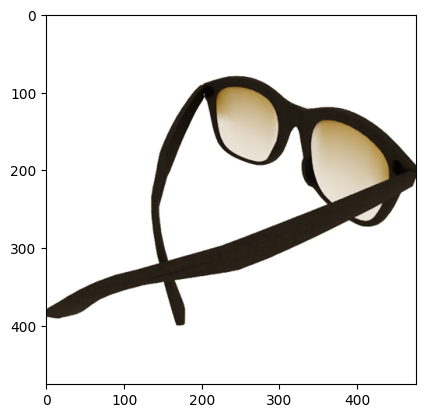

In [42]:
# substitute with your own image path
img_path = 'sunglass.png'
img, background = preprocess_img(img_path)
print(img.shape)
plt.imshow(img)

### Compute DINO features

In [43]:
def get_and_process_dino_features(dinov2, img, background):
    features = get_dino_features(dinov2, img)

    # upsample features to orignal image size
    ratio = img.shape[0] // features.shape[0]
    print(f"original image size: {img.shape}, features size: {features.shape}, ratio: {ratio}")
    features = np.repeat(np.repeat(features, ratio, axis=0), ratio, axis=1)

    # flatten features
    features_flat = features.reshape(-1, features.shape[-1])
    # consider only features in the foreground
    features_flat = features_flat[~background.reshape(-1)]

    # create mapping from feature index to pixel index and vice versa
    feature_id2pixel = dict()
    feature_pixel2id = dict()
    for i, pixel in enumerate(np.argwhere(~background)):
        feature_id2pixel[i] = pixel
        feature_pixel2id[tuple(pixel)] = i


    return features, features_flat, feature_id2pixel, feature_pixel2id

In [44]:
features, features_flat, feature_id2pixel, feature_pixel2id = get_and_process_dino_features(dinov2, img, background)

dict_keys(['x_norm_clstoken', 'x_norm_regtokens', 'x_norm_patchtokens', 'x_prenorm', 'masks'])
original image size: (476, 476, 3), features size: (68, 68, 1024), ratio: 7


In [45]:
def visualize_features(features_flat, background):
    """Visualize PCA results of features"""
    pca = PCA(n_components=3)
    pca.fit(features_flat)
    features_pca = pca.transform(features_flat)
    features_pca = (features_pca - features_pca.min()) / (features_pca.max() - features_pca.min())
    # reshape to original image size (using background mask)
    vis_result = np.zeros_like(img)
    vis_result[~background] = (features_pca * 255).astype(np.uint8) # (n, 3)

    return features_pca, vis_result

In [46]:
features_pca, vis_result = visualize_features(features_flat, background)

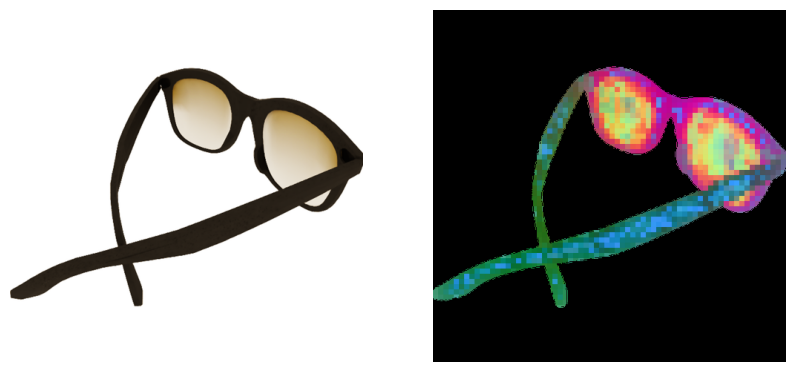

In [47]:
# Plotting images side by side with a margin
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img)
axs[0].axis('off')  # Turn off axis
axs[1].imshow(vis_result)
axs[1].axis('off')  # Turn off axis
# fig.savefig('feature_pca.png')
plt.show()

### Clustering

In [48]:
import numpy as np
from sklearn.cluster import DBSCAN, OPTICS, MeanShift, AffinityPropagation, AgglomerativeClustering
from sklearn import datasets
import random

# some available algorithms
algorithms = [
    ('DBSCAN', DBSCAN(eps=0.01, min_samples=5)),
    ('DBSCAN', DBSCAN(eps=0.5, min_samples=5)),
    ('OPTICS', OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)),
    ('Mean Shift', MeanShift(bandwidth=0.3)),
    ('Affinity Propagation', AffinityPropagation(damping=0.9, max_iter=10)),
    ('Agglomerative Clustering', AgglomerativeClustering(n_clusters=None, distance_threshold=20.0)),
    ('Agglomerative Clustering', AgglomerativeClustering(n_clusters=5, distance_threshold=None))
]

In [49]:
def process_features_for_cluster(features_flat, feature_id2pixel, pca_dim=2, use_loc=True):
    '''
    Process features for clustering.
    pca_dim: PCA features flat to this dimension
    use_loc: whether to use location information in clustering
    '''

    pca = PCA(n_components=pca_dim)
    pca.fit(features_flat)
    _features_pca = pca.transform(features_flat)
    _features_pca = (_features_pca - _features_pca.min()) / (_features_pca.max() - _features_pca.min())

    if use_loc:
        feature_pixels = np.array(list(feature_id2pixel.values()))
        feature_pixels = (feature_pixels - feature_pixels.min(axis=0)) / (feature_pixels.max(axis=0) - feature_pixels.min(axis=0))
        X = np.concatenate((1.0 * _features_pca, 1.0 * feature_pixels), axis=1)
    else:
        X = _features_pca

    return X

In [50]:
def cluster(X, algorithm):
    name, algo = algorithm
    algo.fit(X)

    if hasattr(algo, 'labels_'):
        labels = algo.labels_.astype(int)
    else:
        labels = algo.predict(X)

    # indices of the centroids in the original data X
    centroids_indices = []
    unique_labels = np.unique(labels)
    print(f"{name} found {len(unique_labels)} clusters")

    if name == 'Mean Shift':
        centroids = algo.cluster_centers_
        # Find the closest data point from the original data to each centroid
        centroids_indices = [np.argmin(np.linalg.norm(X - center, axis=1)) for center in centroids]
    elif name == 'Affinity Propagation':
        centroids_indices = algo.cluster_centers_indices_
    else:
        # For DBSCAN, OPTICS, and Agglomerative: compute the mean of each cluster and get the closest point
        for label in unique_labels:
            if label != -1:  # Exclude noise label for DBSCAN and OPTICS
                members = X[labels == label]

                # choose center point as the keypoint
                center = members.mean(axis=0)
                keypoint_idx = np.argmin(np.linalg.norm(X - center, axis=1))

                # choose center point as the keypoint (in last two dimensions)
                # center = members.mean(axis=0)
                # keypoint_idx = np.argmin(np.linalg.norm(X[:, 2:] - center[2:], axis=1))

                # choose point that has the largest distance from center in first two dimensions
                # center = members.mean(axis=0)
                # keypoint_idx = np.argmax(np.linalg.norm(members[:, :2] - center[:2], axis=1))

                centroids_indices.append(keypoint_idx)

    return labels, centroids_indices

In [51]:
def visualize_cluster(X, labels, centroids_indices, feature_id2pixel, img, color_lables=None):
    '''
    color_labels: if None, color all labels; otherwise, color only the specified labels
    '''
    viz = img.copy()
    center_color = (255, 0, 0)

    unique_labels = np.unique(labels)

    # visualize members of each cluster
    # half_size = 3
    for label in unique_labels:
        if color_lables is not None and label not in color_lables:
            continue

        # currently using random color, can be changed to a fixed color
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

        if label != -1:
            members = X[labels == label]
            unique_members = np.unique(members, axis=0)
            for member in unique_members:
                matching_idx = np.argwhere((X == member).all(axis=1))
                for idx in matching_idx:
                    pixel = feature_id2pixel[idx[0]]
                    viz[pixel[0], pixel[1], :] = color

    return viz

In [52]:
# don't consider pixel-space distance, i.e. clustering pixels close to each other
X = process_features_for_cluster(features_flat, feature_id2pixel, pca_dim=2, use_loc=False)

# consider pixel-space distance
# X = process_features_for_cluster(features_flat, feature_id2pixel, pca_dim=2, use_loc=True)

In [53]:
labels, centroids_indices = cluster(X, algorithms[3])

Mean Shift found 3 clusters


In [54]:
vis_all_labels = visualize_cluster(X, labels, centroids_indices, feature_id2pixel, img, color_lables=None)
vis_single_label = visualize_cluster(X, labels, centroids_indices, feature_id2pixel, img, color_lables=[0])

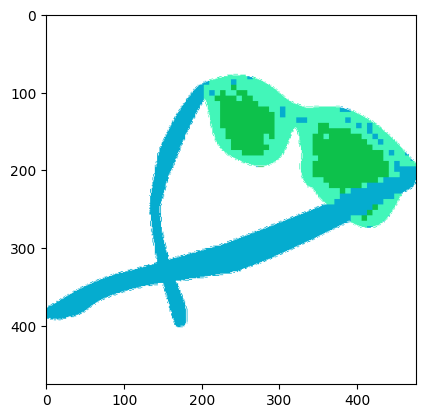

In [55]:
# show clustering visualization
plt.imshow(vis_all_labels)

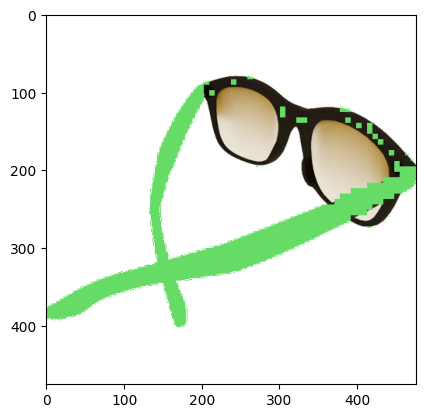

In [56]:
plt.imshow(vis_single_label)

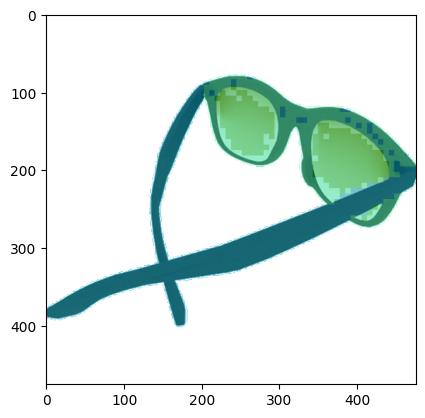

In [57]:
# overlay semi-transparent mask on original image
blended_img = cv2.addWeighted(vis_all_labels, 0.5, img, 0.5, 0)
plt.imshow(blended_img)